# 参数化注意力

In [14]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from lib.d2l_torch import Module, HyperParameters, Trainer, DataModule, plot, show_heatmaps

In [15]:
def plot_kernel_reg(data, y_hat):
    """绘制图像, 将原始数据集和预测的绘制在一起

    Args:
        y_hat (_type_): 预测得到的 y 值
    """
    plot(
        data.x_val, 
        [data.y_val, y_hat.detach().numpy()], 'x', 'y', legend=['Truth', 'Pred'],
        xlim=[0, 5], ylim=[-1, 5]
    )
    plt.plot(data.x_train, data.y_train, 'o', alpha=0.5)

与$非参数化注意力$略有不同， 在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：
$$\begin{aligned}
f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\
& =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left(\left(x-x_i\right) w\right)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left(\left(x-x_j\right) w\right)^2\right)} y_i \\
& =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left(\left(x-x_i\right) w\right)^2\right) y_i .
\end{aligned}$$

将通过训练这个模型来学习注意力汇聚的参数。

## 批量矩阵乘法
为了更有效地计算小批量数据的注意力， 我们可以利用深度学习开发框架中提供的批量矩阵乘法。
假设第一个小批量数据包含$n$个矩阵$X_1,…,X_n$， 形状为$a×b$， 第二个小批量包含$n$个矩阵$Y_1$,…,$Y_n$， 形状为$b×c$。 它们的批量矩阵乘法得到$n$个矩阵 $X_1Y_1,…,X_nY_n$， 形状为$a×c$。 因此，假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$， 它们的批量矩阵乘法输出的形状为$(n,a,c)$。


In [9]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。

In [13]:
weights = np.ones((2, 10)) * 0.1 # [2, 10]
values = np.arange(20).reshape((2, 10)) # [2, 10]
print(np.expand_dims(weights, 1).shape)
print(np.expand_dims(values, -1).shape)
a = np.matmul(np.expand_dims(weights, 1), np.expand_dims(values, -1))
print(a.shape)

(2, 1, 10)
(2, 10, 1)
(2, 1, 1)


## 数据生成

In [16]:
class NonlinearData(DataModule):
    """生成数据集,
     y = 2*sin(x) + x^0.8 + epsilon
    """
    def __init__(self, n, batch_size):
        self.save_hyperparameters()
        f = lambda x: 2 * torch.sin(x) + x**0.8
        self.x_train, _ = torch.sort(torch.rand(n) * 5)
        self.y_train = f(self.x_train) + torch.randn(n) # 用于训练的 label
        self.x_val = torch.arange(0, 5, 5.0/n)
        self.y_val = f(self.x_val) # 用于测试的 label

    def get_dataloader(self, train):
        arrays = (self.x_train, self.y_train) if train else (self.x_val, self.y_val)
        return self.get_tensorloader(arrays, train)

In [17]:
n = 50
data = NonlinearData(n, batch_size=10)

## 定义模型
带参数的注意力汇聚，使用小批量矩阵乘法， 定义Nadaraya-Watson核回归的带参数版本为：

In [18]:
def diff(queries, keys):
    """计算 query 和 key 的距离

    Args:
        queries (_type_): _description_
        keys (_type_): _description_
    """
    return queries.reshape((-1, 1)) - keys.reshape((1, -1))

def attention_pool(query_key_diffs, values):
    attention_weights = F.softmax(- query_key_diffs**2 / 2, dim=1) # 计算权重
    return torch.matmul(attention_weights, values), attention_weights # 权重和 value 相乘

In [19]:
class SGD(HyperParameters):
    """Defined in :numref:`sec_linear_scratch`"""
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        """对 params 进行更新
        """
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [33]:
class NWKernelRegression(Module):
    def __init__(self, keys, values, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.ones(1, requires_grad=True) # w 权重

    def forward(self, queries):
        y_hat, self.attention_weights = attention_pool(
            diff(queries, self.keys) * self.w, self.values)
        return y_hat

    def loss(self, y_hat, y):
        l = (y_hat.reshape(-1) - y.reshape(-1)) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w], self.lr)

## 开始训练

In [36]:
data.x_val

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [35]:
model = NWKernelRegression(data.x_train, data.y_train, lr=0.1) # 初始化模型
model.board.display = False
trainer = Trainer(max_epochs=100)
trainer.fit(model, data)

tensor([1.0484, 0.4414, 3.4609, 1.9368, 3.2004, 4.4029, 2.4992, 2.8842, 2.2241,
        3.0339])
tensor([0.0807, 1.3374, 3.1601, 2.4115, 0.8417, 0.6836, 4.6361, 0.1462, 0.7863,
        0.5421])
tensor([0.7948, 4.3078, 2.5877, 4.1725, 4.5543, 4.9088, 0.9738, 4.4605, 4.7937,
        2.2671])
tensor([0.0078, 3.0302, 4.1726, 2.8247, 2.0897, 3.5366, 1.1058, 1.1007, 4.9752,
        1.3334])
tensor([2.6984, 2.3283, 4.2577, 1.0156, 2.4378, 1.5930, 3.0144, 3.9417, 3.2603,
        2.7255])
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])
tensor([1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000])
tensor([2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000, 2.8000,
        2.9000])
tensor([3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000, 3.6000, 3.7000, 3.8000,
        3.9000])
tensor([4.0000, 4.1000, 4.2000, 4.3000, 4.4000, 4.5000, 4.6000, 4.7000, 4.8000,
        4.9000])
tensor([0.7863, 3.2603, 4.5543

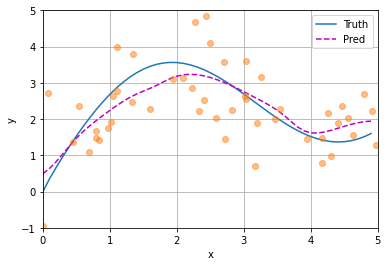

In [22]:
plot_kernel_reg(
    data=data, 
    y_hat=model.forward(data.x_val)
)

注意力权重较大的区域变得更平滑

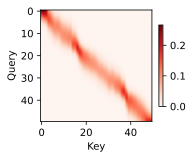

In [26]:
show_heatmaps(
    [[model.attention_weights]],
    xlabel='Key',
    ylabel='Query'
)